In [1]:
!pip install git+https://github.com/kaanaksit/odak.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/kaanaksit/odak.git to /tmp/pip-req-build-ro2y1_he
  Running command git clone -q https://github.com/kaanaksit/odak.git /tmp/pip-req-build-ro2y1_he


In [3]:
import odak
import torch 
import numpy as np 
import odak.learn.raytracing as ODL
import matplotlib.pyplot as plt
import math
import odak.raytracing as raytracer
import odak.tools as tools
import odak.raytracing as raytracer
import torch.nn as nn
from odak.raytracing.ray import create_ray
import cv2
from PIL import Image
import sys
import torch.optim as optim
from torchvision import transforms
import math

In [48]:


class aperture_array():

  def __init__(self, device, image):
    self.device = device
    self.image =image
    self.init_light_sources()
    self.init_aperture_array()
    self.init_detector()
    self.transform_image()
    

  def transform_image(self):
    transform =transforms.Compose([
        transforms.Resize((20, 30)),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
        
    ])

    self.normalised_image = transform(self.image).view(-1,1).to(self.device)
    



  
  def init_light_sources(self, dimensions=[0.01, 0.015], pixel_count=[20, 30], Z=0.):
      x = torch.linspace(-dimensions[0]/2., dimensions[0]/2., pixel_count[0])
      y = torch.linspace(-dimensions[1]/2., dimensions[1]/2., pixel_count[1])
      X, Y = torch.meshgrid(x, y, indexing='ij')
      self.light_source_locations = torch.zeros(X.shape[0], X.shape[1], 3).to(self.device)
      self.light_source_locations[:, :, 0] = X
      self.light_source_locations[:, :, 1] = Y
      self.light_source_locations[:, :, 2] = Z
      
      
  def init_aperture_array(self, dimensions=[0.01, 0.015], pixel_count=[20, 30], Z=0.01):
        x = torch.linspace(-dimensions[0]/2., dimensions[0]/2., pixel_count[0])
        y = torch.linspace(-dimensions[1]/2., dimensions[1]/2., pixel_count[1])
        X, Y = torch.meshgrid(x, y, indexing='ij')
        self.aperture_array_locations = torch.zeros(X.shape[0], X.shape[1], 3).to(self.device)
        self.aperture_array_locations[:, :, 0] = X
        self.aperture_array_locations[:, :, 1] = Y
        self.aperture_array_locations[:, :, 2] = Z
        self.aperture_array = torch.rand(X.shape[0], X.shape[1], requires_grad=True, device=self.device)  #.to(self.device) # makes it differentiable
        # plt.imshow(self.aperture_array.detach().cpu().numpy(), cmap='gray')
        # plt.title('Aperture Array ')

        return self.aperture_array
        
        
  def init_detector(self, dimensions=[0.01, 0.015], size=[20, 30], Z=0.01):
        
        point = torch.tensor([0., 0., Z]).to(self.device)
            #Look into this defination again
        self.detector_surface = odak.learn.raytracing.define_plane(point)
        
        
        # Locations of my pixels on my detector could be defined here.
        
  def intersection_points_to_image(self, points, amplitudes, threshold):
   
        Points_data= self.normalised_image * amplitudes
        detector = torch.zeros_like(Points_data).to(self.device)
        array_locations = self.aperture_array_locations.view(-1, 3)

        for idx, point in enumerate(points):
          
      
          dist_btwn_array_npoint = torch.sqrt(torch.sum((array_locations-point)**2, dim=1))
          min_dist_idx  = torch.argmin(dist_btwn_array_npoint)
          min_dist = torch.min(dist_btwn_array_npoint)

          if min_dist < (math.sqrt(2) * threshold):
            detector[min_dist_idx] = Points_data[idx]
            #print(min_dist)
        detector= detector.view(20, 30)
        return detector
  
  def forward(self, array):
        light_source_locations = self.light_source_locations.view(-1, 3)

        aperture_array_locations = self.aperture_array_locations.view(-1, 3)
      
        aperture_array = array.view(-1, 1)
        detector_image  = torch.zeros(20, 30).to(self.device)
        
        pixel_pitch = torch.sqrt(torch.sum((aperture_array_locations[1] - aperture_array_locations[0])**2, dim =0)).to(self.device)
  
        
        for light_source_location in light_source_locations:
            rays_from_light_source = odak.learn.raytracing.create_ray_from_two_points(light_source_location, aperture_array_locations)

            # print('rays from light: ', rays_from_light_source.size()) #600x2x3
            intersection_normals_w_detector, _ = odak.learn.raytracing.intersect_w_surface(rays_from_light_source, self.detector_surface)
            intersection_points_w_detector = intersection_normals_w_detector[:, 0]
            
            
          # print(intersection_points_w_detector.size())
            detector_image += self.intersection_points_to_image(
                                                                intersection_points_w_detector,
                                                                aperture_array, 
                                                                pixel_pitch
                                                              )  
        return detector_image

  def compute_loss(self, output , target):

    loss = torch.nn.MSELoss()(output, target)

    return loss
            
  def optimize(self):
        
        target= self.normalised_image.view(20, 30)

        array = self.aperture_array
        array_loc = self.aperture_array_locations

        model = [nn.Parameter(array)]
       
        optimiser= torch.optim.SGD(model,lr = 0.001)
        epochs= 100

        # running_loss= 1
        for epoch in range(0, epochs+1):
          optimiser.zero_grad()

          
          output=self.forward(model[0])
          loss = self.compute_loss(output,target)
            
          loss.backward()
          optimiser.step()

          print('Epoch: ', epoch,' ,Loss: ', loss)

        return output
  
def main():
    device = torch.device('cuda')
    apertures = aperture_array(device=device)
    result = apertures.optimize()
    return True


# if __name__ == '__main__':
#     sys.exit(main())






Text(0.5, 1.0, 'Original Image')

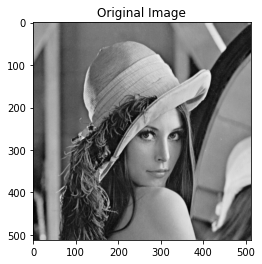

In [49]:
img_G = Image.open('/content/drive/MyDrive/Colab Notebooks/IP Labs/Images/Lenna.png').convert('L')
# img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# img_gray= cv2.resize(img_gray, (30, 20))
# img_G= torch.tensor(img_gray)
plt.imshow(img_G, cmap='gray')
plt.title('Original Image')

In [50]:
# img = cv2.imread('/content/3455 (1).jpg')
# img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# # img_gray= cv2.resize(img_gray, (30, 20))
# img_G= torch.tensor(img_gray)
# plt.imshow(img_G, cmap='gray')
# plt.title('Original Image')

In [51]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test= aperture_array(device, img_G)
array = test.init_aperture_array()

final_im= test.forward(array)


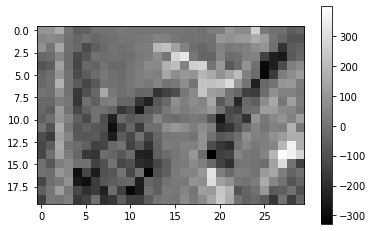

In [52]:
plt.imshow(final_im.cpu().detach().numpy(), cmap='gray')
plt.colorbar()

In [53]:
optim = test.optimize()


Epoch:  0  ,Loss:  tensor(11717.7686, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch:  1  ,Loss:  tensor(6524.8892, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch:  2  ,Loss:  tensor(4138., device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch:  3  ,Loss:  tensor(2905.6125, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch:  4  ,Loss:  tensor(2195.5408, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch:  5  ,Loss:  tensor(1745.2131, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch:  6  ,Loss:  tensor(1436.4644, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch:  7  ,Loss:  tensor(1211.7323, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch:  8  ,Loss:  tensor(1040.7131, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch:  9  ,Loss:  tensor(906.2321, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch:  10  ,Loss:  tensor(797.8679, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch:  11  ,Loss:  tensor(708.9062, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch:  12  ,Loss:  

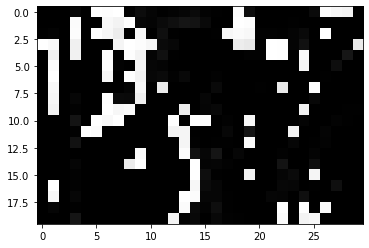

In [59]:
optim =optim.type(torch.float32)
plt.imshow(optim.cpu().detach().numpy(), cmap='gray')

In [58]:
path="/content/drive/MyDrive/Colab Notebooks/MASTERS PROJECT /Models{test1.pth}"
torch.save({'test1':test}, path)